Execute dl_winter_data.sh to download SEN12MSCR dataset and extract it to correct folder structure

In [ ]:
!wget https://syncandshare.lrz.de/dl/fiFfN2bj6DaFXfGEGAaAvdZE/baseline_resnet.pth

In [18]:
import torch
from data.dataLoader import SEN12MSCR
dir_SEN12MSCR = '/home/donatas/projects/gmm-komandinis/data/SEN12MSCR'
sen12mscr     = SEN12MSCR(dir_SEN12MSCR, split='all', region='all')
dataloader    = torch.utils.data.DataLoader(sen12mscr)

print(dataloader[0])

#for pdx, samples in enumerate(dataloader): print(samples['input'].keys())


Processing paths for all split of region all


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


TypeError: 'DataLoader' object is not subscriptable

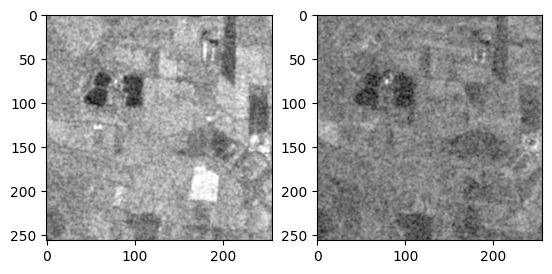

In [22]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

path_IMG = '/home/donatas/projects/gmm-komandinis/data/SEN12MSCR/ROIs2017_winter_s1/s1_102/ROIs2017_winter_s1_102_p102.tif'
tif = rasterio.open(path_IMG)
img = tif.read().astype(np.float32)

# Alternatively, display each channel separately
fig, axes = plt.subplots(nrows=1, ncols=2)
for i, ax in enumerate(axes):
    ax.imshow(img[i, :, :], cmap='gray')
plt.show()

In [27]:
!python train.py --dataroot /home/donatas/projects/gmm-komandinis/data/SEN12MSCR \
    --dataset_mode sen12mscr --name exemplary_training_run --sample_type pretrain \
    --model temporal_branched --netG resnet3d_9blocks_withoutBottleneck --gpu_ids 0 \
    --max_dataset_size 10 --input_type train --cloud_masks s2cloudless_mask \
    --include_S1 --input_nc 15 --output_nc 13 --G_loss L1 --lambda_GAN 0.0 --n_input_samples 3 \
    --display_freq 1000 --region all --alter_initial_model --initial_model_path /home/donatas/projects/gmm-komandinis/data/baseline_resnet.pth

Original sys.argv: ['train.py', '--dataroot', '/home/donatas/projects/gmm-komandinis/data/SEN12MSCR', '--dataset_mode', 'sen12mscr', '--name', 'exemplary_training_run', '--sample_type', 'pretrain', '--model', 'temporal_branched', '--netG', 'resnet3d_9blocks_withoutBottleneck', '--gpu_ids', '0', '--max_dataset_size', '10', '--input_type', 'train', '--cloud_masks', 's2cloudless_mask', '--include_S1', '--input_nc', '15', '--output_nc', '13', '--G_loss', 'L1', '--lambda_GAN', '0.0', '--n_input_samples', '3', '--display_freq', '1000', '--region', 'all', '--alter_initial_model', '--initial_model_path', '/home/donatas/projects/gmm-komandinis/data/baseline_resnet.pth']
----------------- Options ---------------
                   G_loss: L1                            
      alter_initial_model: True                          	[default: False]
               batch_size: 1                             
   benchmark_resnet_model: False                         
                    beta1: 0.5         

In [ ]:
import numpy as np
import torch
import sys
import time
import warnings
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer
import faulthandler; faulthandler.enable() 
import matplotlib.pyplot as plt
from PIL import Image

if __name__ == '__main__':
    sys.argv = ['train.py', '--dataroot', '/home/donatas/projects/gmm-komandinis/data/SEN12MSCR', '--dataset_mode', 'sen12mscr', '--name', 'exemplary_training_run', '--sample_type', 'pretrain', '--model', 'temporal_branched', '--netG', 'resnet3d_9blocks_withoutBottleneck', '--gpu_ids', '0', '--max_dataset_size', '10', '--input_type', 'train', '--cloud_masks', 's2cloudless_mask', '--include_S1', '--input_nc', '15', '--output_nc', '13', '--G_loss', 'L1', '--lambda_GAN', '0.0', '--n_input_samples', '3', '--display_freq', '1000', '--region', 'all', '--alter_initial_model', '--initial_model_path', '/home/donatas/projects/gmm-komandinis/data/baseline_resnet.pth']
    print("Original sys.argv:", sys.argv)
    opt = TrainOptions().parse()   # get training options
    if opt.batch_size !=1:
        warnings.warn(f'Detected batch size {opt.batch_size}, but only supporting batch size 1! Defaulting to 1')
        opt.batch_size = 1          # test code only supports batch_size = 1 # TODO: change this in future versions
    dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
    dataset_size = len(dataset)    # get the number of images in the dataset.
    print('The number of training images = %d' % dataset_size)

    cloudy_cloudfree = dataset.dataset[0]
    print(cloudy_cloudfree['input']['S2'].shape)

    # Combine the 12 channels into a single image
    #new_image.paste(cloudy_cloudfree['input']['S2'][0], (0, 0))


In [49]:


def visualise_rgb(img,clip=[0.3,0.3,0.3],display=True):
        """Visulaise RGB image with given clip values and return image"""

        # Scale image
        # img = np.clip(img/10000,0,1)
        
        # Get RGB channels
        rgb = img[[3,2,1]]

        # #clip rgb values
        # rgb[0] = np.clip(rgb[0],0,clip[0])/clip[0]
        # rgb[1] = np.clip(rgb[1],0,clip[1])/clip[1]
        # rgb[2] = np.clip(rgb[2],0,clip[2])/clip[2]

        rgb = rgb.transpose(1,2,0)

        if display:

                #Display histograms of pixel intesity with given clip values
                fig, axs = plt.subplots(1,4,figsize=(22,5))
                fig.patch.set_facecolor('xkcd:white')

                labels = ['Red','Green','Blue']
                for i,ax in enumerate(axs[0:3]):
                        ax.hist(img[3-i].flatten(),bins=100)
                        ax.set_title(labels[i],size=20,fontweight="bold")
                        ax.axvline(clip[i],color="red",linestyle="--")
                        ax.set_yticks([])

                #Display RGB image
                axs[3].imshow(rgb)
                axs[3].set_title("RGB",size=20,fontweight="bold")
                axs[3].set_xticks([])
                axs[3].set_yticks([])

        return rgb



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


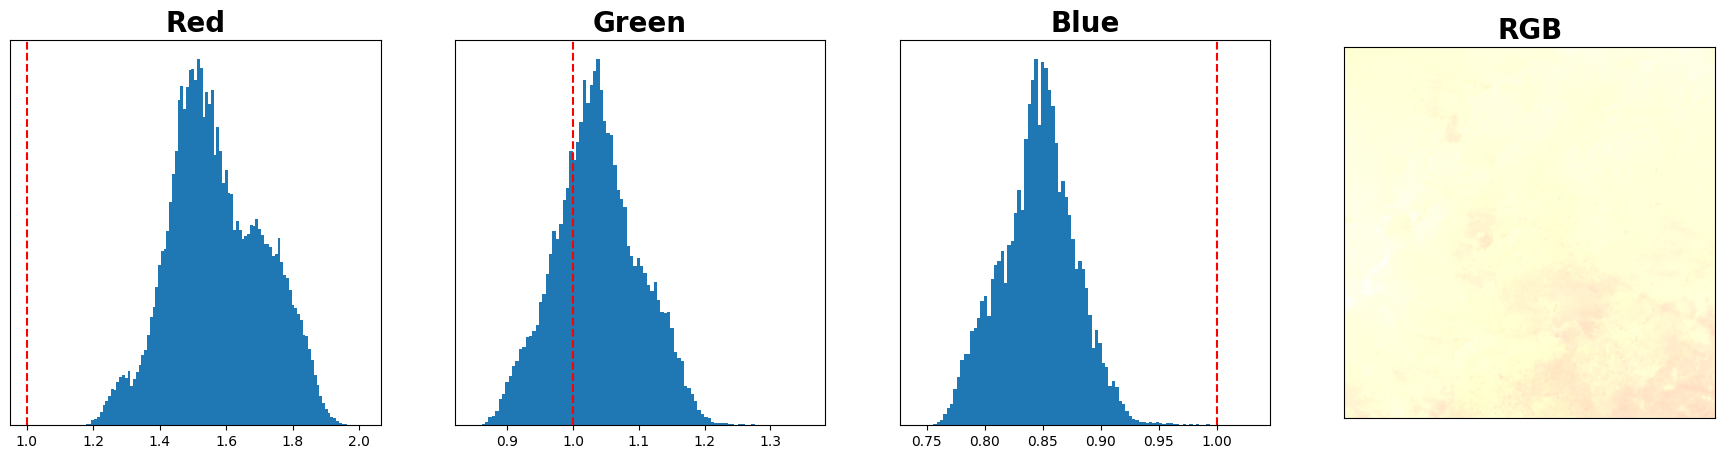

In [52]:
img = cloudy_cloudfree['input']['S2']
rgb_1 = visualise_rgb(img,[1.0,1.0,1.0])

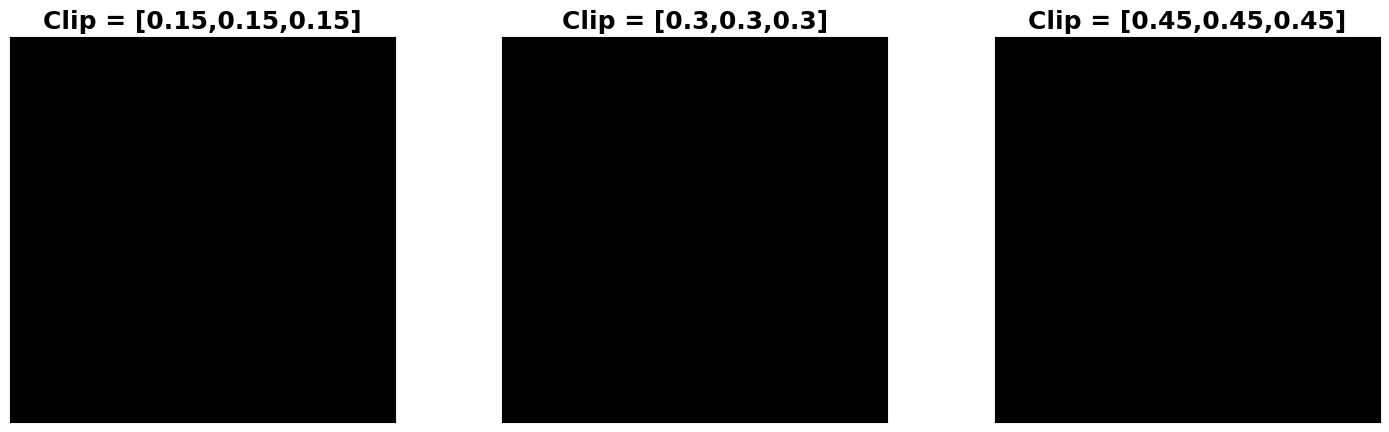

In [47]:
img = cloudy_cloudfree['input']['S2']

rgb_1 = visualise_rgb(img,[0.15,0.15,0.15],display=False)
rgb_2 = visualise_rgb(img,[0.3,0.3,0.3],display=False)
rgb_3 = visualise_rgb(img,[0.45,0.45,0.45],display=False)

# Plot RGB images with different clip values
fig, axs = plt.subplots(1,3,figsize=(18,5))
fig.patch.set_facecolor('xkcd:white')

axs[0].imshow(rgb_1)
axs[0].set_title("Clip = [0.15,0.15,0.15]",size=18,fontweight="bold")

axs[1].imshow(rgb_2)
axs[1].set_title("Clip = [0.3,0.3,0.3]",size=18,fontweight="bold")

axs[2].imshow(rgb_3)
axs[2].set_title("Clip = [0.45,0.45,0.45]",size=18,fontweight="bold")

# remove ticks
for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
